# Install

In [1]:
! pip install memory_profiler
%load_ext memory_profiler 

Defaulting to user installation because normal site-packages is not writeable


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn  # Speeds up sklearn with intel patch
patch_sklearn()  # Activate patch - changes sklearn imports below

from timeit import default_timer as timer # Time how long commands take
from sklearn.model_selection import train_test_split, StratifiedKFold  # test_train split, cross-validation

from sklearn.experimental import enable_iterative_imputer  # Iterative imputer experimental so need to enable it
from sklearn.impute import IterativeImputer  # Once enabled iterative imputer can be imported

from sklearn.linear_model import RidgeClassifier, BayesianRidge  # Imputation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder  # Normalisation & Encoding
from imblearn.under_sampling import TomekLinks, RandomUnderSampler   # Undersampling
from imblearn.over_sampling import SMOTENC  # Oversampling
from sklearn.feature_selection import RFE, RFECV  # Recursive feature elimination - feature selection
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier  # RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier

import pickle

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Variables

In [3]:
# Number of cores being used 
n_jobs = 10

In [4]:
# Random State
random_state = 14

# General Functions

In [5]:
# Stopwatch to profile function runtimes
class Stopwatch:

    # Initiate constructor
    def __init__(self):
        self.start = timer()
        self.end = None
        self.runtime = None

    # Stop stopwatch
    def stop(self):
        self.end = timer()
        self.runtime = self.end - self.start
        return self.runtime

In [6]:
# Find which columns are categorical and which continuous
def cat_con_cols(df):
    
    columns = [list(df[i]) for i in df]  # Nested list of column values
    num_unique_vals = [len(set([i for i in a if pd.notna(i)])) for a in columns]  # Num of unique values in a column

    categorical_indexes = [i for i, v in enumerate(num_unique_vals) if v <= 100
                           and set([a % 1 for a in df[df.columns[i]].dropna()]) == {0}]

    continuous_indexes = [i for i, v in enumerate(num_unique_vals) if v > 100 or
                          set([a % 1 for a in df[df.columns[i]].dropna()]) != {0}]

    cat = list(df.columns[categorical_indexes])
    con = list(df.columns[continuous_indexes])
    return cat, con

# Data Cleaning

In [7]:
# Read in data
df = pd.read_csv('/data/home/bt211037/dissertation/feats_selected_dataset.tsv',
                   sep='\t', header=0, index_col=0)

### Convert categorical columns to integers

In [8]:
# Get the column names of the continuous and categorical data
cat, con = cat_con_cols(df)  

In [9]:
# Convert categorical cols values from floats to integers 
df[cat] = df[cat].astype('Int64')  

### Separate categorical and Continuous features in dataframe¶
This makes indexing certain features in later processess easier. Continuous features are the first columns followed by categorical.


In [10]:
df = pd.concat([df[con], df[cat]], axis=1, join="inner")

# Column indexes for categorical and continuous features
# Important to exclude target feature - thryoid_cancer
categorical_indexes = [i for i, x in enumerate(df.columns[0:34]) if x in cat]
continuous_indexes = [i for i, x in enumerate(df.columns) if x in con]

# Test Train Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'thyroid_cancer'],
                                                        df['thyroid_cancer'],
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=random_state,
                                                        stratify=df['thyroid_cancer'])

# Pipeline

### Imputation
Testing three types of imputation:
- Simple Imputation
- Multiple imputation
- KNN imputation

In [12]:
# Simple imputer 
simp_imputer = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(missing_values=np.nan, strategy='median'),
             continuous_indexes),

            ('cat', SimpleImputer(missing_values=np.nan, strategy='constant',
                                  fill_value=4444),
             categorical_indexes)

        ])

In [13]:
# Multiple imputation with iterative imputer
imputer = ColumnTransformer(
    transformers=[
        ('num', IterativeImputer(initial_strategy='median',
                                 max_iter=5,
                                 random_state=random_state), 
         continuous_indexes),
        
        ('cat', IterativeImputer(estimator=RidgeClassifier(),
                                 initial_strategy='most_frequent',
                                 max_iter=10, 
                                 random_state=random_state), 
         categorical_indexes)
    
    ])

In [14]:
# KNN imputer
knn_imp = KNNImputer(n_neighbors=1)

### Sampling Methods
Tomek Links Undersampling and SMOTENC oversampling will be used to address class imbalance. This will be compared with using no sampling methods.

In [15]:
# Tomek Links undersampling
tl = TomekLinks(sampling_strategy='majority')

In [16]:
# SMOTE oversampling
smote = SMOTENC(random_state=random_state,
                categorical_features=categorical_indexes,
                sampling_strategy=1)

### Predictive model
Will be using MLP from sklearn.

In [17]:
# MLP
mlp_model = MLPClassifier(random_state=random_state)

# Random Undersampling
Undersample the majority class in the dataset to provide a smaller dataset for hyperparamter tuning. Training on this smaller dataset even seems to give better results than on the full dataset.

Reduces the data from ~300,000 to ~6,000 rows/samples.

In [18]:
# Configure random undersampler
rus = RandomUnderSampler(sampling_strategy=0.1,
                         random_state=random_state)

In [19]:
# Create the dataset used for hyperparamter tuning and training
X_res, y_res = rus.fit_resample(X_train, y_train.astype('float64'))

In [20]:
X_res

,Whole body fat-free mass|x23101_0_0,Whole body water mass|x23102_0_0,Leg fat percentage (right)|x23111_0_0,Leg predicted mass (right)|x23114_0_0,Leg fat percentage (left)|x23115_0_0,Leg fat-free mass (left)|x23117_0_0,Leg predicted mass (left)|x23118_0_0,Arm fat-free mass (right)|x23121_0_0,Arm predicted mass (right)|x23122_0_0,Arm fat-free mass (left)|x23125_0_0,...,Other eye problems|x2227_0_0,Falls in the last year|x2296_0_0,Acceptability of each blow result|x3061_0_0,Number of measurements made|x3137_0_0,Illness injury bereavement stress in last 2 years|x6145_0_0,Types of transport used (excluding work)|x6162_0_0,Illnesses of siblings|x20111_0_0,Spirometry QC measure|x20255_0_0,Genetic sex|x22001_0_0,Above moderate/vigorous/walking recommendation|x22036_0_0
0,40.1,29.4,38.0,6.3,38.6,6.5,6.2,2.1,1.9,2.1,...,0,2,<NA>,<NA>,0,1,3,<NA>,0,1
1,58.6,42.9,11.7,8.8,11.8,9.0,8.5,3.1,2.9,3.3,...,0,1,0,2,0,1,8,1,1,1
2,37.9,27.7,35.7,6.2,36.6,6.3,6.0,1.8,1.6,1.8,...,1,1,32,2,0,1,9,1,0,1
3,38.3,28.0,37.7,6.0,36.7,6.4,6.0,1.8,1.7,1.9,...,0,1,0,3,0,1,8,1,0,1
4,52.3,38.3,39.4,7.9,39.0,8.3,7.9,2.7,2.5,2.8,...,1,1,<NA>,<NA>,2,1,<NA>,<NA>,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034,39.4,28.8,23.4,6.3,26.4,6.3,6.0,2.0,1.9,1.9,...,0,1,0,3,0,2,<NA>,2,0,1
6035,40.2,29.4,33.4,6.3,34.4,6.5,6.1,2.0,1.8,2.0,...,1,1,2,3,0,1,0,<NA>,0,1
6036,38.6,28.3,41.5,6.1,41.7,6.4,6.0,1.9,1.7,2.0,...,0,3,2,3,0,1,12,<NA>,0,<NA>
6037,35.9,26.3,33.3,5.8,34.0,6.0,5.6,1.6,1.5,1.6,...,0,1,0,2,0,1,0,<NA>,0,<NA>


# Training

In [21]:
# Training on undersampled dataset

In [22]:
# Optimal Model
o_mlp_model = MLPClassifier(random_state=random_state,
                            activation='tanh',
                            alpha=0.0001,
                            hidden_layer_sizes=100,
                            learning_rate='constant',
                            max_iter=500,
                            solver='sgd')

In [23]:
knn_mlp_pipe = imbpipeline(steps = [('imputer', knn_imp),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', o_mlp_model)])

In [24]:
%%memit

# Model Training
t=Stopwatch()

knn_mlp_pipe.fit(X_res, y_res.values.ravel())

print(t.stop())

5.825724575668573
peak memory: 933.38 MiB, increment: 431.15 MiB


In [25]:
# Predictions on the test data
y_preds = knn_mlp_pipe.predict(X_test)

In [26]:
y_test = list(y_test)

In [27]:
y_preds = y_preds.astype('int64')

In [28]:
# Model evaluation
f1_score(y_test, y_preds)

0.0035778175313059034

In [29]:
accuracy_score(y_test, y_preds)

0.8166301581473087

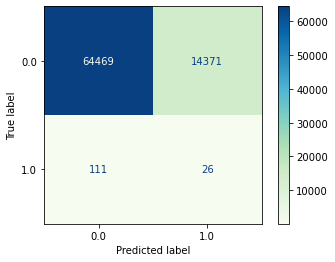

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds, labels=knn_mlp_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_mlp_pipe.classes_)
disp.plot(cmap='GnBu')
plt.show()

# Train on full dataset

In [31]:
full_mult_mlp_pipe = imbpipeline(steps = [('imputer', imputer),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', o_mlp_model)])

In [32]:
%%memit

# Model Training
t=Stopwatch()

full_mult_mlp_pipe.fit(X_train, list(y_train))

print(t.stop())

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


638.4102900139987
peak memory: 4740.83 MiB, increment: 4159.71 MiB


In [33]:
# Predictions on the test data
full_y_preds = full_mult_mlp_pipe.predict(X_test)

In [34]:
full_y_test = list(y_test)

In [35]:
full_y_preds = full_y_preds.astype('int64')

In [36]:
# Model evaluation
f1_score(full_y_test, full_y_preds)

0.00435650753312761

In [37]:
accuracy_score(full_y_test, full_y_preds)

0.9305494004583613

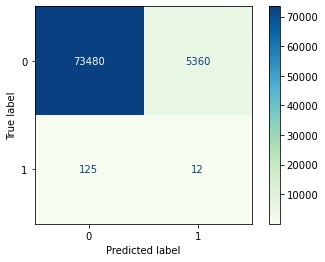

In [38]:
# Confusion Matrix
full_cm = confusion_matrix(full_y_test, full_y_preds, labels=full_mult_mlp_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=full_cm,
                              display_labels=full_mult_mlp_pipe.classes_)
disp.plot(cmap='GnBu')
plt.show()

# Save Model

In [39]:
# Saving best performing model

model_file = '/data/home/bt211037/dissertation/mlp_model.pkl'

pickle.dump(full_mult_mlp_pipe, open(model_file, 'wb'))